# Source

This project is shared on gitub at [https://github.com/btrapp/covidmortality2020](https://github.com/btrapp/covidmortality2020)
please feel free to submit pull requests to improve it or clone it to continue your own work.
---

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
# disable chained assignments
pd.options.mode.chained_assignment = None 

---
# Data Sources 

For the source of data, lets use the "Weekly Counts of Deaths by State and Select Causes" data from the CDC.

2019-2020: [https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6](https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6)

2014-2018: [https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr](https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr)

Download these two datasets as CSVs and name them death_2020.csv and death_2018.csv.  A copy from when I first ran this on Nov 28 2020 is provided in the github repo.


In order to reduce ambiguity, lets ONLY use the "All Cause" column from this dataset, which tracks deaths per
 week from all causes, so we don't have to worry about if the underlying cause of death was attributed correctly
 or not.  Let's just see if we can compare total death rates in 2020 to the historical averages of 2014-2019 for the same periods.
 
Also, fun fact, the dataset contains deaths by jurisdiction for each state, plus summary rows at the end of the dataset for the entire US.  So don't just sum up all the data by year/week or you'll double count.  Google says 2.8 million people died in 2018 so there's a quick sanity checkpoint.




In [2]:
#Read the csv files
df2020all = pd.read_csv('death_2021.csv'); 
#df2020all.head()

#Drop all columns except Juristiction, Year, Week, and All Cause
df2020=df2020all.iloc[:, [0, 1, 2, 4]] 

#Read the 2014-2019 file
df2018all = pd.read_csv('death_2019.csv'); 
#df2018all.head()

#Drop all columns except Juristiction, Year, Week, and All Cause
df2018=df2018all.iloc[:, [0, 1, 2, 4]] 

#Check one file
print(df2018[:2])
print(df2018[-2:])


  Jurisdiction of Occurrence  MMWR Year  MMWR Week  All  Cause
0              United States       2014          1       54065
1              United States       2014          2       56353
      Jurisdiction of Occurrence  MMWR Year  MMWR Week  All  Cause
16900                Puerto Rico       2019         51         577
16901                Puerto Rico       2019         52         553


---
# Data Cleanup

- One annoying problem is that the "All Cause" column is "All Cause" in one dataset, and "All  Cause" (two spaces) in the other.
- Also, the dataset contains rows for state-level data plus a US-level summary.  Keep only the US level summary rows.
- The first and last points in the dataset (for just US-level) are outliers and should be removed.


In [3]:
#In order to be able to merge them cleanly, lets set the columns to a more helpful set of consistent names.
df2020.columns=['Jurisdiction','Year','Week', 'Deaths']
df2018.columns=['Jurisdiction','Year','Week', 'Deaths']

#Merge the dataframes together
dfAllRaw = pd.concat([df2018,df2020])
# More cleanup - We don't need the data broken out by each state, there's a summary row for ALL states
#  called just 'United States'.  Select just those rows.
dfUsRaw = dfAllRaw[dfAllRaw['Jurisdiction'] == 'United States'] 

#The first and last records in the final dataset are suspiciously low, and look outlier-y.  Lets remove them
dfUs = dfUsRaw.iloc[1:].iloc[:-1]

#Check our work
print(dfUs[:2])
print(dfUs[-2:])

    Jurisdiction  Year  Week   Deaths
1  United States  2014     2  56353.0
2  United States  2014     3  54769.0
     Jurisdiction  Year  Week   Deaths
63  United States  2021    11  46557.0
64  United States  2021    12  38620.0


---
# Feature Engineering

In [4]:
#Add a helpful column that's the year and week joined together with short weeks like 4 padded to '04'
yr = dfUs['Year'].astype(str)+'-'+dfUs['Week'].astype(str).str.pad(2,fillchar='0')
dfUs['YYYY-WW'] = yr

#We also need a time based column that's numeric for use in a regression and to make plotting easier.
#Encode Year-Week as a fraction of a year (each week is one 52nd of a year, but need to start counting at 0 not 1)
dfUs['YearValue'] = dfUs['Year']+ ((dfUs['Week']-1)/52.0)

print(dfUs[:2])
print(dfUs[-2:])

#Lets keep a variable around to represent March 2020, when things started to get crazy:
MARCH2020 = 2020 + ((3-1)/12.0)


    Jurisdiction  Year  Week   Deaths  YYYY-WW    YearValue
1  United States  2014     2  56353.0  2014-02  2014.019231
2  United States  2014     3  54769.0  2014-03  2014.038462
     Jurisdiction  Year  Week   Deaths  YYYY-WW    YearValue
63  United States  2021    11  46557.0  2021-11  2021.192308
64  United States  2021    12  38620.0  2021-12  2021.211538


In [5]:
##Try a polar plot to see if it makes the data a little easier to visualise
#dfUs['WeekRadians'] = (2 * np.pi)*((dfUs['Week']-1)/52.0)
#plt.figure(figsize=(12,8))
#plt.polar(dfUs.loc[dfUs['Year']<2020]['WeekRadians'],dfUs.loc[dfUs['Year']<2020]['Deaths'])
#plt.polar(dfUs.loc[dfUs['Year']>=2020]['WeekRadians'],dfUs.loc[dfUs['Year']>=2020]['Deaths'])
##Eh - by week is fine.

2832001.0


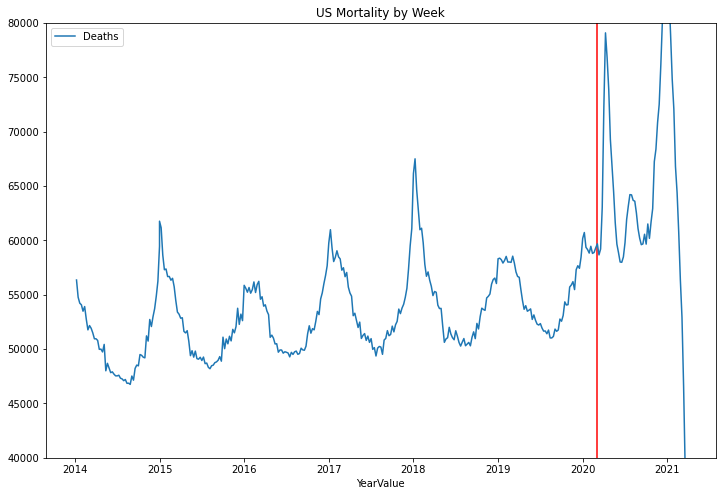

In [6]:
#Just a sanity check - should be about 2.8 million 
totalDeathsIn2018 = dfUs.loc[dfUs['Year']==2018]['Deaths'].sum();
print(totalDeathsIn2018)

#And visualise the data:
dfUs.plot(title='US Mortality by Week',x='YearValue',y=['Deaths'],figsize=(12,8),ylim=(40000,80000))
plt.vlines(MARCH2020,dfUs.Deaths.min(),dfUs.Deaths.max(),color='red')

# A closer look

That periodicity really is striking.  While the previous chart's y-axis scale makes it helpful to see variation, 
it makes it hard to get a sense of the relative scale of the data.  Lets look at it again forcing the y-axis min 
value to zero so that we can get a better sense of the peaks relative to the overall rate.

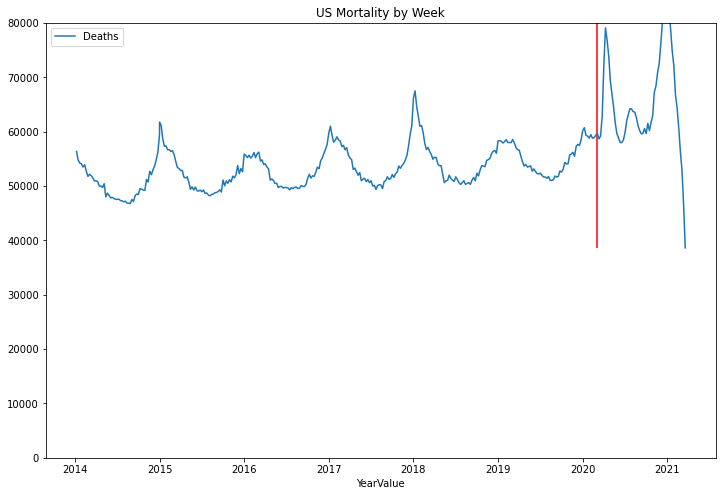

In [7]:
#And visualise the data:
dfUs.plot(title='US Mortality by Week',x='YearValue',y=['Deaths'],figsize=(12,8),ylim=(0,80000))
plt.vlines(MARCH2020,dfUs.Deaths.min(),dfUs.Deaths.max(),color='red')

---
# Basic steps

- In order to determine if the behavior in 2020 is 'expected' or not, lets first
 build a model to predict the expected mortality rate
- Lets build & evaluate the quality of our model on our 2014-2019 data
- Then lets use the model to predict what "should" have happened in 2020 and compare that to what's actually happened.


---
# What's a "normal" number of people that die by week?

From looking at the above plots, there is a *strong* cyclical component there, right?  Any analysis we do had better take that into account. 

Lets start with 2014-2019 in a dataframe called 'dfOld' and look at the data by week-of-year:

In [8]:
#Lets figure out what the *normal* number of deaths per week is.  
#dfOld is a dataframe of everything *except* 2020's deaths:
dfOld = dfUs[dfUs['Year'] < 2020]

#Lets try a simple mean/median by week:
avgDeathsDf = dfOld.groupby('Week').agg({'Deaths':[np.median,np.mean]}).reset_index()
print(avgDeathsDf[:2])
print(avgDeathsDf[-2:])
vals = avgDeathsDf.values;

dictMedian = {a : b for a,b,c in vals}
dictMean = {a : c for a,b,c in vals}
print(dictMedian)

  Week   Deaths         
         median     mean
0    1  59764.0  60367.8
1    2  59672.5  59993.0
   Week   Deaths              
          median          mean
51   52  56948.5  57016.833333
52   53  59457.0  59457.000000
{1.0: 59764.0, 2.0: 59672.5, 3.0: 58436.0, 4.0: 57603.5, 5.0: 57760.0, 6.0: 57596.5, 7.0: 57341.0, 8.0: 57066.0, 9.0: 56603.0, 10.0: 56665.0, 11.0: 55458.0, 12.0: 55292.5, 13.0: 54432.5, 14.0: 54617.5, 15.0: 54179.0, 16.0: 53117.5, 17.0: 52392.5, 18.0: 52175.5, 19.0: 51496.5, 20.0: 50546.0, 21.0: 50712.0, 22.0: 50380.0, 23.0: 50671.0, 24.0: 50357.0, 25.0: 50335.5, 26.0: 50186.0, 27.0: 50333.5, 28.0: 49807.0, 29.0: 49708.0, 30.0: 49532.5, 31.0: 49800.5, 32.0: 49992.5, 33.0: 50002.0, 34.0: 49518.0, 35.0: 50101.5, 36.0: 50192.5, 37.0: 50505.0, 38.0: 50561.0, 39.0: 50613.5, 40.0: 51763.0, 41.0: 51716.5, 42.0: 51848.0, 43.0: 52215.0, 44.0: 52706.0, 45.0: 52903.5, 46.0: 53619.5, 47.0: 53646.5, 48.0: 54686.5, 49.0: 55385.0, 50.0: 56209.0, 51.0: 56644.5, 52.0: 56948.5, 53.0

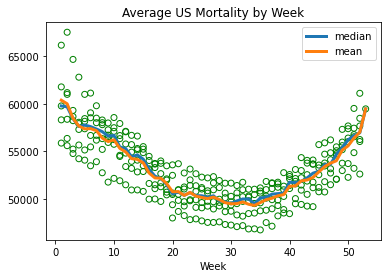

In [9]:
#Plot overall mortality by week of year.  
avgDeathsDf.plot.line(x='Week', y='Deaths',title='Average US Mortality by Week',linewidth=3)
plt.scatter(x=dfOld['Week'],y=dfOld['Deaths'],facecolors='none', edgecolors='g')
#Wow the ends of the year are dangerous times to be alive

In [10]:
#Now put the expected # of deaths by week back into the dataframe using a map of the dicts we created earlier
dfUs['ExpectedDeathsMedian'] = dfUs['Week'].map(dictMedian)
dfUs['ExpectedDeathsMean'] = dfUs['Week'].map(dictMean)


#And, because machine learning is the new hotness, lets try using XGBoost to build a 
# regression model for a more sophisticated predictor:
#Big thanks for this guy: https://www.geeksforgeeks.org/xgboost-for-regression/
xgBoostDfXold = dfOld[['YearValue', 'Week']].copy()
xgBoostDfYold = dfOld['Deaths'].copy()
train_X, test_X, train_y, test_y = train_test_split(xgBoostDfXold, xgBoostDfYold, test_size = 0.3, random_state=42) 
 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123) 
xgb_r.fit(train_X, train_y) 

# Use the model to predict our test data
xgbPredTest = xgb_r.predict(test_X) 

#Now use it to predict ALL the values in the dataset
xgBoostDfXall = dfUs[['YearValue', 'Week']].copy()
xgbPredAll = xgb_r.predict(xgBoostDfXall) 

#Or by using the XGBoost predicted series directly.
dfUs['ExpectedDeathsXgb'] = xgbPredAll


#What's the R2 value for our predicted vs actual for 2014-2019?
rmseMed = np.sqrt(mean_squared_error(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsMedian'])) 
rmseMea = np.sqrt(mean_squared_error(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsMean'])) 
rmseXgb = np.sqrt(mean_squared_error(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsXgb'])) 
print("RMSE Median:",rmseMed,"RMSE Mean:",rmseMea,"RMSE XGBoost:",rmseXgb)

#Of the 3 techniques, Mean has the lowest RMSE (1932)

RMSE Median: 1877.5039105937628 RMSE Mean: 1850.3484663729012 RMSE XGBoost: 2107.9694937275203


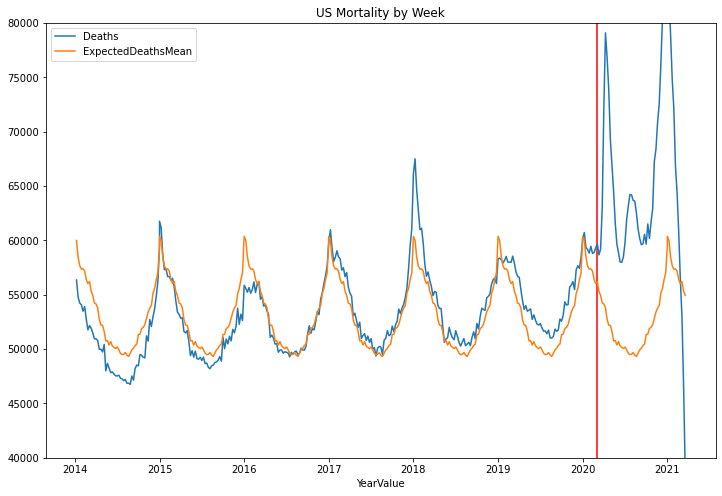

In [11]:
dfUs.plot(title='US Mortality by Week',x='YearValue',y=['Deaths','ExpectedDeathsMean'],figsize=(12,8),ylim=(40000,80000))
#Draw a line at March 2020
plt.vlines(MARCH2020,dfUs.Deaths.min(),dfUs.Deaths.max(),color='red')

---
Lets plot the rediduals - The actuals - predicteds


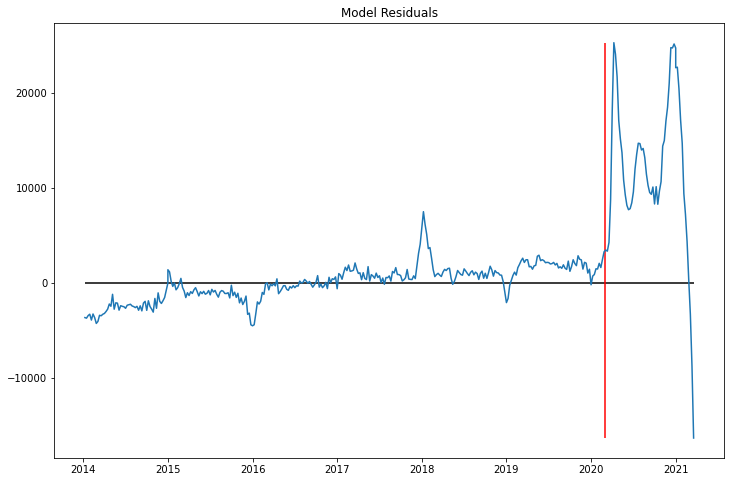

In [12]:
residualsY = dfUs['Deaths']-dfUs['ExpectedDeathsMean']
residualsX = dfUs['YearValue']
plt.figure(figsize=(12,8))
plt.plot(residualsX.to_numpy(),residualsY.to_numpy())
plt.title("Model Residuals")
plt.hlines(0,min(residualsX), max(residualsX),color='black')
plt.vlines(MARCH2020,min(residualsY),max(residualsY),color='red')

---
# Improving the Model

Can we do a little bit better?  It looks like there's a general issue where the model over predicts older data and under predicts newer data.  

The first model really only looked at average death rates by week, and doesn't have any way to account for the fact that the overall US population is growing over time and we'd expect death rates to naturally follow.  What if we first used a simple linear regression by time to account for a gradual increase in death rates, then take the residuals of those predictions and put *those* into the average-by-week logic.  


In [13]:
#Guide -https://realpython.com/linear-regression-in-python/
x = dfOld['YearValue'].to_numpy().reshape((-1, 1))
y = dfOld['Deaths'].to_numpy()

model = LinearRegression().fit(x,y)
#print(f)
y_pred = model.predict(x)

#Calculate the residuals left after applying the year based model:
yPredResiduals = dfOld['Deaths']-y_pred
week = dfOld['Week']
#print(dy)

dfYearAdjusted = pd.DataFrame()
dfYearAdjusted['YearValue'] = dfOld['YearValue']
dfYearAdjusted['Year'] = dfOld['Year']
dfYearAdjusted['Week'] = dfOld['Week']
dfYearAdjusted['PredDeathResidual'] = yPredResiduals
#print(dfYearAdjusted)

#Lets try a simple mean/median by week as two simple predictors
avgDeathsDfAdv = dfYearAdjusted.groupby('Week').agg({'PredDeathResidual':[np.median,np.mean]}).reset_index()
print(avgDeathsDfAdv[:2])
print(avgDeathsDfAdv[-2:])
valsAdv = avgDeathsDfAdv.values;

dictMedianAdv = {a : b for a,b,c in valsAdv}
dictMeanAdv = {a : c for a,b,c in valsAdv}
print(dictMeanAdv)

  Week PredDeathResidual             
                  median         mean
0    1       6765.138739  7368.938739
1    2       6748.647719  7344.791005
   Week PredDeathResidual             
                   median         mean
51   52       3983.129759  3667.319806
52   53       7916.852166  7916.852166
{1.0: 7368.938739015907, 2.0: 7344.791005126433, 3.0: 5807.098247815389, 4.0: 4978.738823837484, 5.0: 4668.546066526401, 6.0: 4679.019975882101, 7.0: 4453.9938852376845, 8.0: 3665.3011279264465, 9.0: 3277.1083706154022, 10.0: 3449.7489466377688, 11.0: 2537.056189326647, 12.0: 2148.8634320154088, 13.0: 1431.83734137107, 14.0: 1336.81125072677, 15.0: 962.1184934156094, 16.0: -119.74093056206281, 17.0: -649.600354539929, 18.0: -688.6264451842289, 19.0: -1264.9858691620564, 20.0: -2142.1786264730617, 21.0: -2142.2047171175946, 22.0: -2552.2308077618945, 23.0: -2254.2568984064274, 24.0: -2660.949655717394, 25.0: -2816.30907969526, 26.0: -2946.835170339599, 27.0: -2801.861260984093, 28.0: 

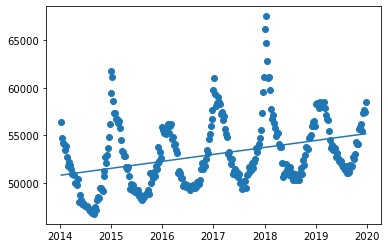

In [14]:
#Here's the linear fit of the 2014-2019 data:
plt.plot(x,y_pred)
plt.scatter(x=dfOld['YearValue'],y=dfOld['Deaths'])

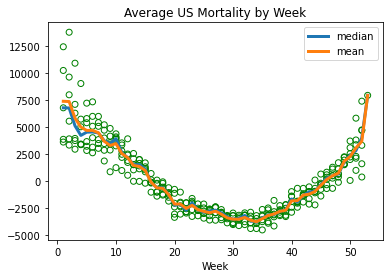

In [15]:
#Plot overall mortality by week of year.  
avgDeathsDfAdv.plot.line(x='Week', y='PredDeathResidual',title='Average US Mortality by Week',linewidth=3)
plt.scatter(x=dfYearAdjusted['Week'],y=dfYearAdjusted['PredDeathResidual'],facecolors='none', edgecolors='g')
#Wow the ends of the year are dangerous times to be alive

In [16]:
#Now run the yearly predictor for all the data and add in the expected mean residual by week:
yPredYear = model.predict(dfUs['YearValue'].to_numpy().reshape((-1, 1)))
dfUs['PredJustYear']=yPredYear #The year component
dfUs['PredJustMonth']=dfUs['Week'].map(dictMeanAdv) #The week component
dfUs['ExpectedDeathsAdv']=dfUs['PredJustYear']+dfUs['PredJustMonth']
dfUs.head()

,Jurisdiction,Year,Week,Deaths,YYYY-WW,YearValue,ExpectedDeathsMedian,ExpectedDeathsMean,ExpectedDeathsXgb,PredJustYear,PredJustMonth,ExpectedDeathsAdv
1,United States,2014,2,56353.0,2014-02,2014.019231,59672.5,59993.000000,53578.167969,50824.817211,7344.791005,58169.608216
2,United States,2014,3,54769.0,2014-03,2014.038462,58436.0,58469.333333,53578.167969,50838.843302,5807.098248,56645.941550
3,United States,2014,4,54223.0,2014-04,2014.057692,57603.5,57655.000000,52955.765625,50852.869392,4978.738824,55831.608216
4,United States,2014,5,54074.0,2014-05,2014.076923,57760.0,57358.833333,52955.765625,50866.895483,4668.546067,55535.441550
5,United States,2014,6,53484.0,2014-06,2014.096154,57596.5,57383.333333,52955.765625,50880.921574,4679.019976,55559.941550


In [17]:
#Is our advanced "year + week" model actually better (a lower RMSE?)

rmseMea = np.sqrt(mean_squared_error(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsMean'])) 
rmseMeaAdv = np.sqrt(mean_squared_error(dfUs[dfUs['Year'] < 2020]['Deaths'], dfUs[dfUs['Year'] < 2020]['ExpectedDeathsAdv'])) 
print("RMSE Mean (Week only model):",rmseMea,"RMSE Mean (Year+Week model):",rmseMeaAdv)

#We dropped RMSE from 1932 to 1140!

RMSE Mean (Week only model): 1850.3484663729012 RMSE Mean (Year+Week model): 1121.3301388161785


---
# Model Improved!

The RMSE of our model dropped from 1932 (when we just use the week mean) to 1140 (when we used the time based linear regression plus the week mean of the residuals.)

In [18]:
#Use the expected death mean values to calculate the amount of deaths that are above or below what we'd expect 
# from our historical model
dfUs['ExtraDeathsMean'] = dfUs['Deaths']-dfUs['ExpectedDeathsAdv']


# Results

Plot the actual number of deaths by week versus the "expected" number of deaths for that week from our previously calculated averages.

Things to look for:
 - Do deaths & expected deaths track well in our historical data?
 - Sections where the blue line is above the orange line means more people are dying in that week than the historical averages would suggest

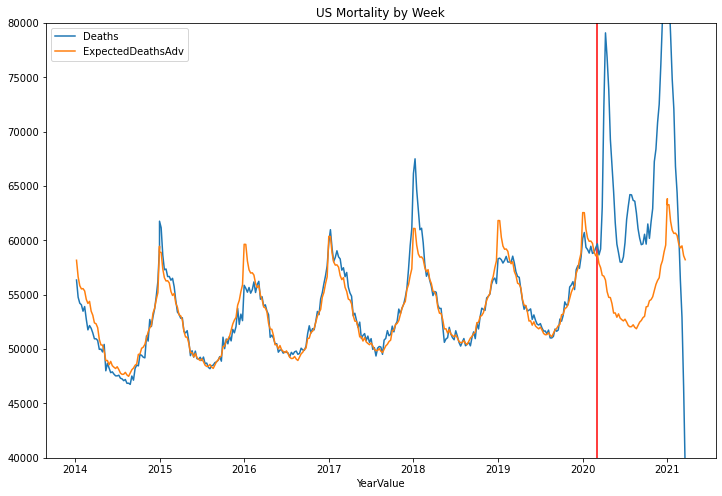

In [19]:
dfUs.plot(title='US Mortality by Week',x='YearValue',y=['Deaths','ExpectedDeathsAdv'],figsize=(12,8),ylim=(40000,80000))
#Draw a line at March 2020
plt.vlines(MARCH2020,dfUs.Deaths.min(),dfUs.Deaths.max(),color='red')

---
This model fits our historical data much better, so I trust its 2020 predictions better than the previous iteration.

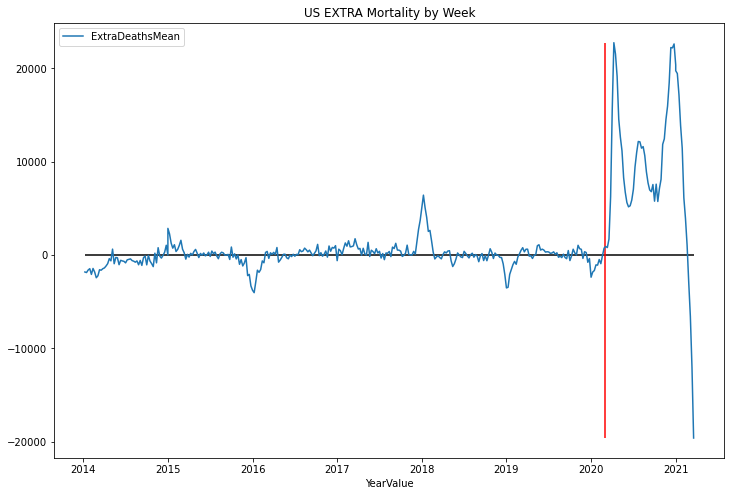

In [20]:
dfUs.plot(title='US EXTRA Mortality by Week',x='YearValue',y=['ExtraDeathsMean'],figsize=(12,8))
#Draw a line at y=0 (where expected deaths=actual deaths)
plt.hlines(0,min(dfUs['YearValue']), max(dfUs['YearValue']),color='black')
#Draw a line at March 2020
plt.vlines(MARCH2020,dfUs.ExtraDeathsMean.min(),dfUs.ExtraDeathsMean.max(),color='red')

---
# Intepreting the results

There's a pretty clear deviation from 'normal' staring in early 2020 and remaining strong through the rest of the year. Independent of why its pretty obvious that a lot more people are dying now than compared to the trend suggested by historical data.  

Lets just put some numbers behind 'pretty obvious' - Lets use a ttest to see if the populations pre and post March 2020 could be considered equal:


In [21]:
#Lets split the data into pre and post March 2020 
preMarch2020 = dfUs[dfUs.YearValue < MARCH2020]['ExtraDeathsMean'].to_numpy()
pstMarch2020 = dfUs[dfUs.YearValue >= MARCH2020]['ExtraDeathsMean'].to_numpy()

#Use the t-test to test if these populations are the same:
tResults = ttest_ind(preMarch2020,pstMarch2020,equal_var=False)
print(tResults)
print()

#Sum up the deviations from expected post March 2020:
totalExtraDeaths = round(np.sum(pstMarch2020));
totalDeaths = round(np.sum(dfUs[dfUs.YearValue >= MARCH2020]['Deaths'].to_numpy()));
print("Since March 2020, there were",(format(totalExtraDeaths, ',d')) ,"more deaths than expected by the historical model");
pct = round(totalExtraDeaths * 100 / totalDeaths)
print("This represents ",pct,"% of all deaths in this period.")

Ttest_indResult(statistic=-8.62605644343653, pvalue=7.997884322193939e-12)

Since March 2020, there were 533,812 more deaths than expected by the historical model
This represents  15 % of all deaths in this period.


---
The pvalue is low enough (< 0.05) to confidently reject the idea that the mortality rates after March 2020 are from a similar population as the previous values.



# Suggestions for future work:
 - ~~Try using a simple ML model like XGBoost for a more sophisticated expected death rate predictor~~ (turns out mean was still a better predictor!)
 - ~~The "EXTRA Mortality" shows I still have a time based bias.  I bet correcting historical averages for US population by year would help account for that.~~ Splitting the model into a contiuous linear fit plus a by-week mean of the rediduals helped reduce the RMSE from 1932 to 1165
 - ~~Why can't i get nice x-axis tickmarks showing the start of each year?  Darn you matplotlib!~~ Encoding YYYY-WW into a year fraction (2020-05 -> 2020+(5-1/52)) makes for much nicer plots
 